#### Import packages

In [11]:
import ipynb.fs.defs.MILP_v1_Stedin_BaseCase as BC
import ipynb.fs.defs.MILP_v1_Stedin_DetStoch as OC

from pyomo.environ import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use({'figure.facecolor':'white'})


#### Define Model Inputs

In [12]:
data = OC.read_input(r'Input_Files\InputDataVreeswajk_v3_1d.xlsx')
Sbase = 1000 #kVA
Vnom = 10/np.sqrt(3)    #kV
Zbase = (Vnom**2)*1000/Sbase # Ohm
Ibase = Sbase/Vnom/1000 #kA
Vmax = 1.04  #pu
Vmin = 0.96  #pu
#Base case, Stochastic case, Deterministic case, Stochastic Case
# eta_conf = ['BC', 0.1, 0.5, 0.9]
eta_conf = ['BC', 0.5, 0.1, 0.9]

#### Initialize dataframes to store results

In [13]:
MCCost = pd.DataFrame()
MCLosses = pd.DataFrame()
MCSlack = {name: pd.DataFrame() for name in eta_conf}
MCVolt = {name: pd.DataFrame() for name in eta_conf}
MCLoading = {name: pd.DataFrame() for name in eta_conf}

#### Run all 4 cases + Monte Carlo on each solution

In [14]:
for eta in eta_conf:
    print('\n\nSIMULATION STARTING FOR $\eta$ = '+str(eta));print('\n\n')
    case = 'BC' #start each iteration with a BASE CASE
    if eta == 'BC':
        #solve base case (fixed load profiles)
        solver = SolverFactory('ipopt')
        base_model = BC.optimization_model(data, Vmax, Vmin, Vnom, Sbase, Zbase, Ibase, case, 0.5, 0)
        solver.solve(base_model, tee=True)
    else:
        #solve the optimization problem for different value of eta
        solver = SolverFactory('gurobi')
        solver.options['timelimit'] = 3000
        solver.options['mipgap'] = 3/100    # X%/100%
        base_model = OC.optimization_model(data, Vmax, Vmin, Vnom, Sbase, Zbase, Ibase, case, eta, 0)
        solver.solve(base_model, tee=True)

    #run Monte Carlo on each situation and store output data
    case = 'MC'; solver = SolverFactory('ipopt')
    print('\n\nRUNNING MONTE CARLO FOR $\eta$ = '+str(eta));print('\n\n')
    for k in range(100):
        if eta == 'BC':
            MC_model = BC.optimization_model(data, Vmax, Vmin, Vnom, Sbase, Zbase, Ibase, case, 0.5, base_model)
            solver.solve(MC_model)#, tee=True)
        else:
            MC_model = OC.optimization_model(data, Vmax, Vmin, Vnom, Sbase, Zbase, Ibase, case, eta, base_model)
            solver.solve(MC_model)#, tee=True)

        #store voltage and slack loading for each case and all MC iterations
        voltage = pd.DataFrame()
        slack = pd.DataFrame()
        for t in MC_model.TIME:
            for n in MC_model.NODES:
                voltage.loc[t, n] = np.sqrt(MC_model.V[n,t].value)
                if n == 8284:
                    slack.loc[t,n] = np.sqrt((MC_model.Ps[n,t].value*Sbase)**2 + (MC_model.Qs[n,t].value*Sbase)**2)
        MCVolt[eta] = pd.concat([MCVolt[eta],voltage], ignore_index=True, sort=False) #pu
        MCSlack[eta] = pd.concat([MCSlack[eta],slack], ignore_index=True, sort=False) # kVA

        # store line loading for each case and all MC iterations
        loading = pd.DataFrame()
        for i,j in MC_model.LINES:
            for t in MC_model.TIME:
                s = str(i) + '-' + str(j)
                loading.loc[t, s] = np.sqrt(MC_model.I[i,j,t].value)/(3*MC_model.I_max[i,j].value)*100
        MCLoading[eta] = pd.concat([MCLoading[eta],loading], ignore_index=True, sort=False) #%

        #store objective function of DSO
        MCCost.loc[k, eta] = value(MC_model.obj) #$
        #store network losses
        MCLosses.loc[k, eta] = sum(value(MC_model.RM[i,j])*value(MC_model.I[i,j,t]) for i,j in MC_model.LINES for t in MC_model.TIME)*Sbase # kWh/day
    print('\n\nMC FINISHED FOR $\eta$ = '+str(eta));print('\n\n')



SIMULATION STARTING FOR $\eta$ = BC



Ipopt 3.12.13: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.13, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:    15888
Number of nonzeros in inequality constraint Jacobian.:     1008
Number of nonzeros in Lagrangian Hessian.............:     2952

Total number of variables............................:     4080
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     varia

#### Visualize Data

In [15]:
# #DSO Objective Cost -> PDF
# fig, ax = plt.subplots(figsize=(12,8))
# # ax.hist(MCCost, density=True, edgecolor='black', linewidth=0.5)
# MCCost.plot(ax=ax, kind='density', legend=False)
# ax.set_title('DSO Objective Cost');ax.set_xlabel('Cost [$/day]');ax.set_ylabel('PDF')
# fig.legend(['$\eta = $'+str(i) for i in eta_conf], bbox_to_anchor=(0.75,0.75), loc='center', borderaxespad=0);

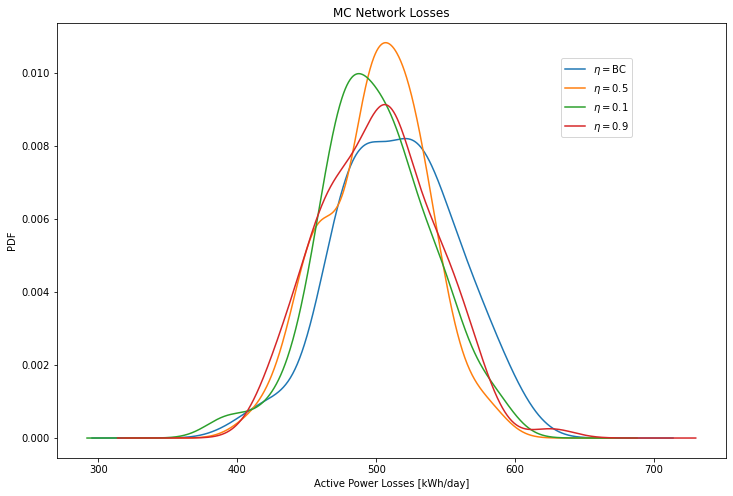

In [16]:
#Network Losses -> PDF
fig, ax = plt.subplots(figsize=(12,8))
# ax.hist(MCLosses, density=True, edgecolor='black', linewidth=0.5)
MCLosses.plot(ax=ax, kind='density', legend=False)
ax.set_title('MC Network Losses');ax.set_xlabel('Active Power Losses [kWh/day]');ax.set_ylabel('PDF')
fig.legend(['$\eta = $'+str(i) for i in eta_conf], bbox_to_anchor=(0.75,0.75), loc='center', borderaxespad=0);

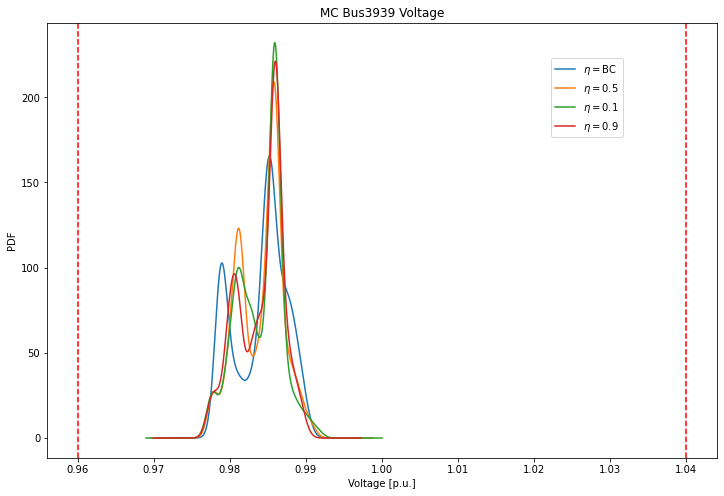

In [17]:
#Voltage with maximum variance -> PDF
fig, ax = plt.subplots(figsize=(12,8))
V = MCVolt['BC'].var().idxmax()
for name, df in MCVolt.items():
    # V = df.var().idxmax()
    # ax.hist(df.loc[:, V], density=True, edgecolor='black', linewidth=0.5)
    df.loc[:, V].plot(kind='density')
ax.axvline(Vmax, color='r', linestyle='--', label='$V_{max}$')
ax.axvline(Vmin, color='r', linestyle='--', label='$V_{min}$')
ax.set_title('MC Bus'+str(V)+' Voltage');ax.set_xlabel('Voltage [p.u.]');ax.set_ylabel('PDF')
fig.legend(['$\eta = $'+str(i) for i in eta_conf], bbox_to_anchor=(0.75,0.75), loc='center', borderaxespad=0);

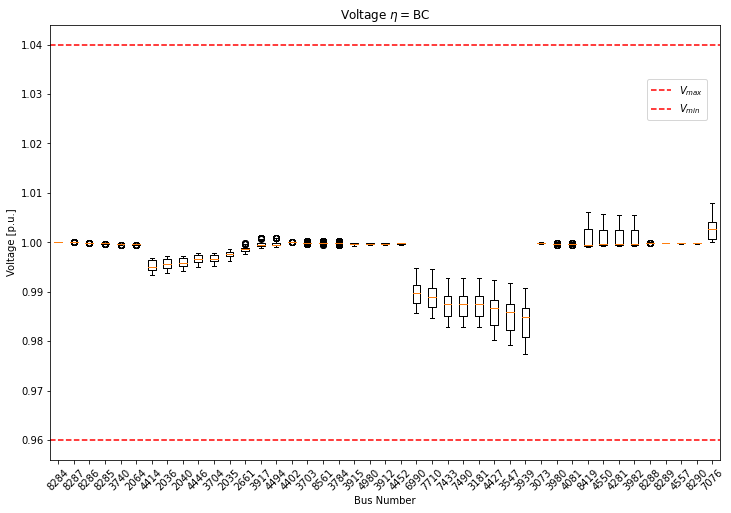

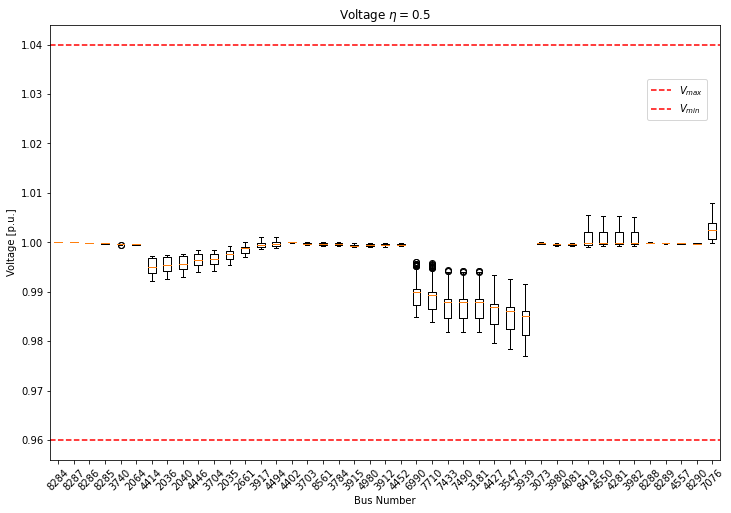

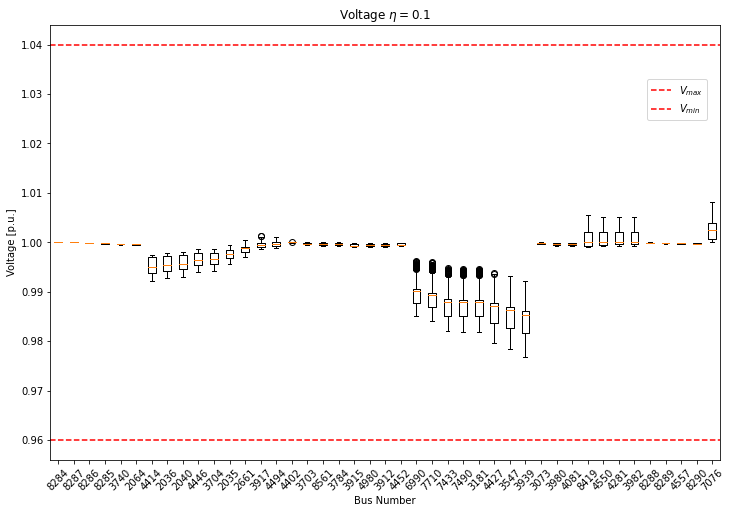

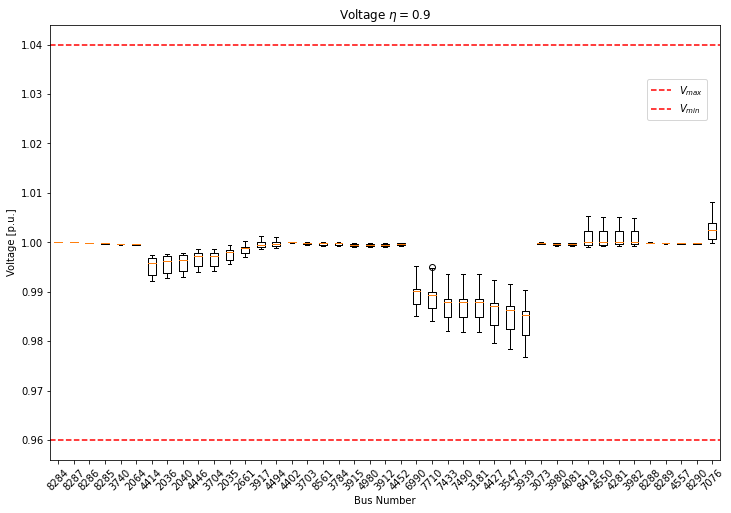

In [18]:
#Voltage distribution for each case -> Box plot
for name, df in MCVolt.items():
    figMCV, axMCV = plt.subplots(nrows=1, ncols=1, squeeze=False, figsize=(12,8))
    axMCV[0,0].set_title('Voltage $\eta = $'+str(name));axMCV[0,0].set_xlabel('Bus Number');axMCV[0,0].set_ylabel('Voltage [p.u.]')
    axMCV[0,0].boxplot(df)
    axMCV[0,0].axhline(Vmax, color='r', linestyle='--', label='$V_{max}$')
    axMCV[0,0].axhline(Vmin, color='r', linestyle='--', label='$V_{min}$')
    axMCV[0,0].set_xticklabels(df.columns, rotation=45)
    figMCV.legend(bbox_to_anchor=(0.85,0.75), loc='center', borderaxespad=0);
# figMCV.tight_layout()
# plt.savefig('Visualization/MC_voltage.png', bbox_inches='tight')
# plt.close()

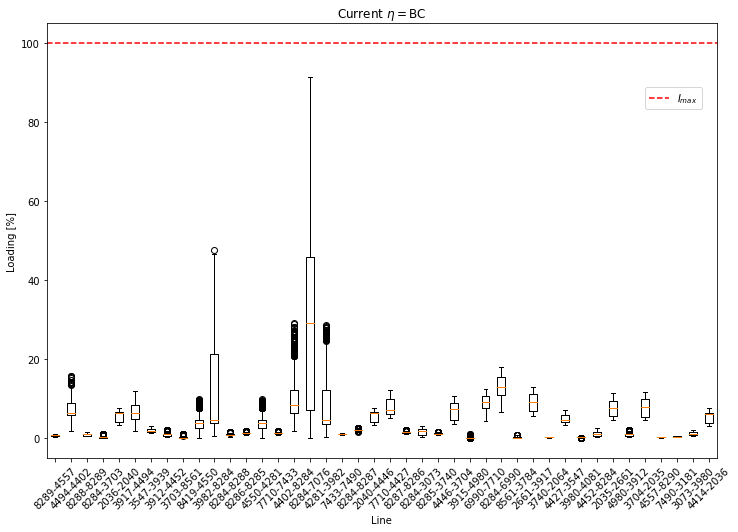

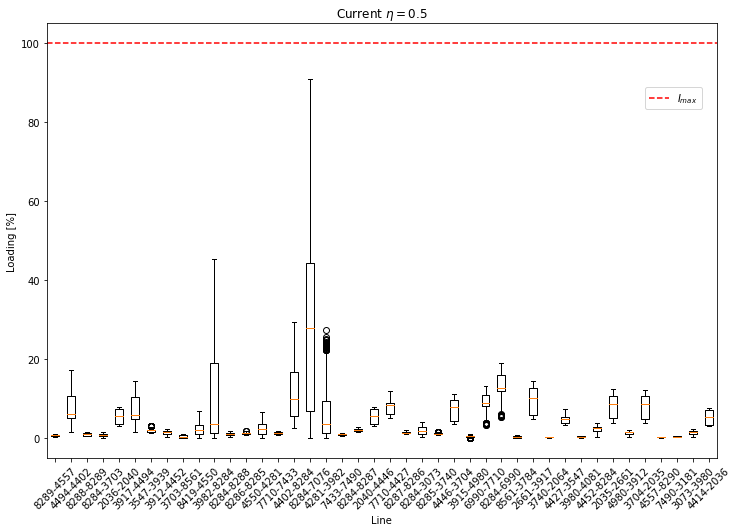

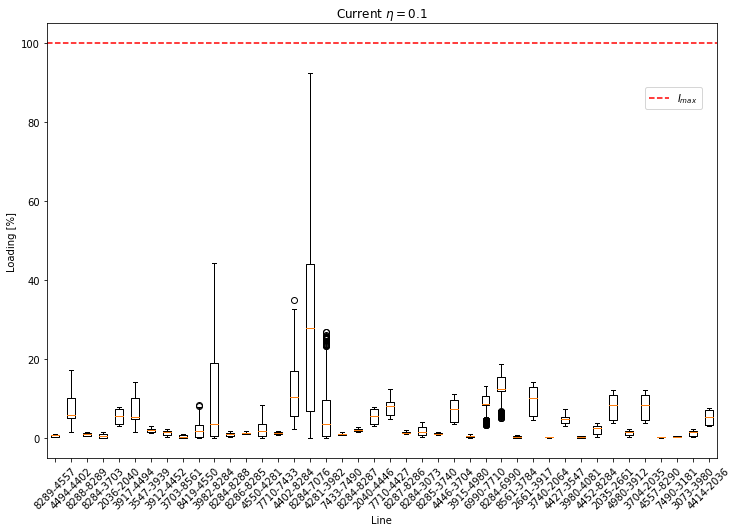

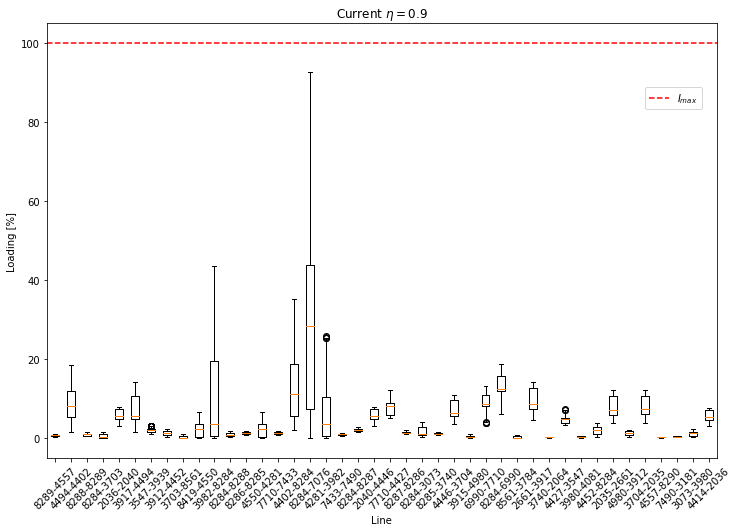

In [19]:
#Line loading distribution for each case -> Box plot
for name, df in MCLoading.items():
    figMCL, axMCL = plt.subplots(nrows=1, ncols=1, squeeze=False, figsize=(12,8))
    axMCL[0,0].set_title('Current $\eta = $'+str(name));axMCL[0,0].set_xlabel('Line');axMCL[0,0].set_ylabel('Loading [%]')
    axMCL[0,0].boxplot(df)
    axMCL[0,0].axhline(100, color='r', linestyle='--', label='$I_{max}$')
    axMCL[0,0].set_xticklabels(df.columns, rotation=45)
    figMCL.legend(bbox_to_anchor=(0.85,0.75), loc='center', borderaxespad=0);
# figMCL.tight_layout()
# plt.savefig('Visualization/MC_loading.png', bbox_inches='tight')
# plt.close()

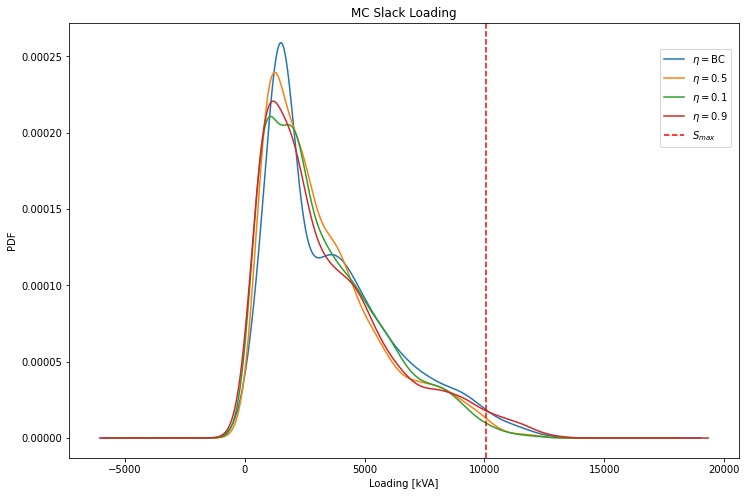

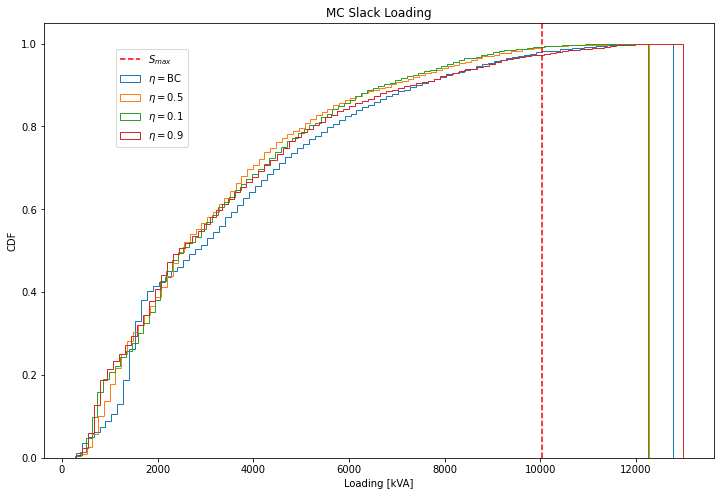

In [20]:
#Slack loading -> PDF
Smax = base_model.Ss_max[8284].value*Sbase
fig, ax = plt.subplots(figsize=(12,8))
for name, df in MCSlack.items():
    # ax.hist(df, density=True, edgecolor='black', linewidth=0.5, bins=25)
    df.plot(ax=ax, kind='density', legend=False)
ax.axvline(Smax, color='r', linestyle='--', label='$S_{max}$')
ax.set_title('MC Slack Loading');ax.set_xlabel('Loading [kVA]');ax.set_ylabel('PDF')
fig.legend(['$\eta = $'+str(i) for i in eta_conf]+['$S_{max}$'], bbox_to_anchor=(0.85,0.75), loc='center', borderaxespad=0);
# fig.tight_layout()
# plt.savefig('Visualization/MC_trafoPDF.png', bbox_inches='tight')
# plt.close()

fig1, ax1 = plt.subplots(figsize=(12,8))
for name, df in MCSlack.items():
    ax1.hist(df, bins=100, density=True, cumulative=True, label='CDF', histtype='step')
ax1.set_title('MC Slack Loading');ax1.set_xlabel('Loading [kVA]');ax1.set_ylabel('CDF')
ax1.axvline(Smax, color='r', linestyle='--', label='$S_{max}$')
fig1.legend(["$S_{max}$"]+['$\eta = $'+str(i) for i in eta_conf], bbox_to_anchor=(0.25,0.75), loc='center', borderaxespad=0);
# fig1.tight_layout()
# plt.savefig('Visualization/MC_trafoCDF.png', bbox_inches='tight')
# plt.close()